# Choose colours for tiff

The output tiff from QGIS has a single channel ("band"), a 2D grid that contains object ID values from the .geojson file. To plot the tiff in colour, we need to convert this 1 x 2D grid into 4 x 2D grid - one channel each for RGBA (Red/Green/Blue/Alpha).

The colours are selected based on the outcome we wish to plot. Effectively the selection is the same as using a discrete colormap.

## Setup

In [66]:
import numpy as np
import pandas as pd

# For importing the cog raster image:
import rasterio
# For plotting:
import matplotlib.pyplot as plt
# For colour conversion:
from PIL import ImageColor
# For saving and loading new tiffs:
# import tifffile as tiff
from osgeo import osr
# For reading in the metadata of existing geotiff:
from osgeo.gdalconst import GA_ReadOnly
from osgeo import gdal
# For speeding up colour-allocation function:
from numba import jit
# For conversion to cog:
import leafmap

### Import the raster image

In [5]:
in_tiff = 'LSOA_raster2.tif'

with rasterio.open(in_tiff, 'r') as f:
    tif_array = f.read()

### Import the LSOA --> OBJECTID table

In [63]:
df_objectids = pd.read_csv('./lsoa_objectids.csv')

df_objectids.head()

,LSOA11NM,LSOA11CD,OBJECTID
0,City of London 001A,E01000001,1
1,City of London 001B,E01000002,2
2,City of London 001C,E01000003,3
3,City of London 001E,E01000005,4
4,Barking and Dagenham 016A,E01000006,5


### Import the outcome values

In [20]:
df_lsoa_outcomes = pd.read_csv('./lsoa_base.csv')

# df_lsoa_outcomes.head()
df_lsoa_outcomes.head(3).T

,0,1,2
lsoa,Adur 001A,Adur 001B,Adur 001C
closest_ivt_unit,BN25BE,BN25BE,BN112DH
closest_ivt_time,17.6,18.7,17.6
closest_mt_unit,BN25BE,BN25BE,BN25BE
closest_mt_time,17.6,18.7,19.8
...,...,...,...
mothership_nlvo_ivt_mean_shift,-0.56,-0.56,-0.56
mothership_lvo_ivt_improved,0.17,0.17,0.16
mothership_lvo_mt_improved,0.75,0.75,0.75
mothership_nlvo_ivt_improved,0.56,0.56,0.56


The following columns are in the dataframe:

+ lsoa
+ closest_(ivt/mt)_unit
+ closest_(ivt/ivt)_time
+ transfer_mt_unit
+ transfer_mt_time
+ mt_transfer_required
+ msu_unit
+ msu_time
+ (ivt/mt)_drip_ship
+ (ivt/mt)_mothership

The following can begin with either drip_ship_(lvo/nlvo)_ or mothership_(lvo/nlvo)_:

+ (untreated/ivt/mt)_probs
+ (untreated/ivt/mt)_mean_utility       
+ (ivt/mt)_added_utility
+ (untreated/ivt/mt)_cum_probs
+ (untreated/ivt/mt)_mrs<=2
+ (ivt/mt)_shift
+ (untreated/ivt/mt)_mean_mRS
+ (ivt/mt)_mean_shift
+ (ivt/mt)_improved


# Example: mapping LSOA names to raster

We'll map the Isles of Scilly because their outline is distinctive.

In [65]:
df_objectids[df_objectids['LSOA11NM'].str.contains('Scilly')]

,LSOA11NM,LSOA11CD,OBJECTID
18535,Isles of Scilly 001A,E01019077,18536


The Isles of Scilly have OBJECTID 18536. Pull out the values containing it:

In [6]:
inds_IOS = np.where(tif_array[0] == 18536)

grid_IOS = tif_array[0][
    min(inds_IOS[0]):max(inds_IOS[0]),
    min(inds_IOS[1]):max(inds_IOS[1])
]

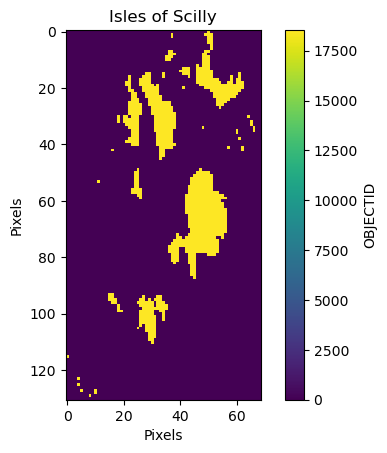

In [7]:
plt.imshow(grid_IOS, cmap='viridis', interpolation='none')
plt.colorbar(label='OBJECTID')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Isles of Scilly')
plt.show()

Now we can create an image of this where the sea is transparent and Scilly is lime green.

In [8]:
# 'LimeGreen' = '#32cd32' and either works in the following lines.
colour_IOS_string = '#32cd32' 
colour_IOS_rgb = ImageColor.getcolor(colour_IOS_string, 'RGB')

colour_IOS_rgb

(50, 205, 50)

In [9]:
# Add an alpha channel.
# Because the other values are 0-255 integer RGB, we have alpha=0 for transparent
# and alpha=255 for opaque.
# When using 0.0-1.0 float RGB, use alpha 0.0 for transparent and 1.0 for opaque.
colour_IOS_rgba = (colour_IOS_rgb[0], colour_IOS_rgb[1], colour_IOS_rgb[2], 255)

Make a set of 4 x 2D grids for the colour channels.

In [10]:
raster_IOS = np.full((*grid_IOS.shape, 4), 0)

raster_IOS.shape

(131, 69, 4)

Find the coordinates containing Scilly:

In [11]:
inds_IOS = np.where(grid_IOS > 0)

Update those coordinates with the LimeGreen value:

In [67]:
raster_IOS[inds_IOS[0], inds_IOS[1], :] = colour_IOS_rgba

Example of one of the rows of data in the blue (band 2) grid:

In [68]:
raster_IOS[:, :, 2][1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50, 50,
       50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0])

Draw the image using imshow:

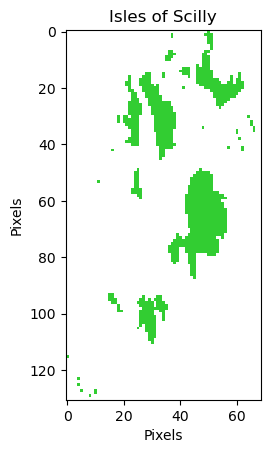

In [69]:
plt.imshow(raster_IOS, interpolation='None')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Isles of Scilly')
plt.show()

In this way we can map any colour we like to any area we like.

# Example: Choosing colour boundaries from a colourmap

This section shows how to get just a few colours from a colourmap, but of course we could use a continuous scale.

Setup: which colour map to use, the range of outcomes we're mapping, and how many colours to use.

In [70]:
cmap = 'inferno'

# These outcomes are selected at random:
outcome_min = 0.0
outcome_max = 2.4
n_colours = 6

outcome_bounds = np.linspace(outcome_min, outcome_max, n_colours + 1)
colour_bounds = np.linspace(0, 1, n_colours)

Get RGBA colours from the colour map:

In [16]:
colours = plt.get_cmap(cmap)(colour_bounds)

colours

array([[1.46200e-03, 4.66000e-04, 1.38660e-02, 1.00000e+00],
       [2.58234e-01, 3.85710e-02, 4.06485e-01, 1.00000e+00],
       [5.78304e-01, 1.48039e-01, 4.04411e-01, 1.00000e+00],
       [8.65006e-01, 3.16822e-01, 2.26055e-01, 1.00000e+00],
       [9.87622e-01, 6.45320e-01, 3.98860e-02, 1.00000e+00],
       [9.88362e-01, 9.98364e-01, 6.44924e-01, 1.00000e+00]])

Reshape to an NxMx4 array for plotting the colours in a column with imshow():

In [17]:
colours_rgba = colours.reshape(n_colours, 1, 4)

print(colours_rgba.shape)

colours_rgba

(6, 1, 4)


array([[[1.46200e-03, 4.66000e-04, 1.38660e-02, 1.00000e+00]],

       [[2.58234e-01, 3.85710e-02, 4.06485e-01, 1.00000e+00]],

       [[5.78304e-01, 1.48039e-01, 4.04411e-01, 1.00000e+00]],

       [[8.65006e-01, 3.16822e-01, 2.26055e-01, 1.00000e+00]],

       [[9.87622e-01, 6.45320e-01, 3.98860e-02, 1.00000e+00]],

       [[9.88362e-01, 9.98364e-01, 6.44924e-01, 1.00000e+00]]])

Draw the colours with the range in outcomes of each:

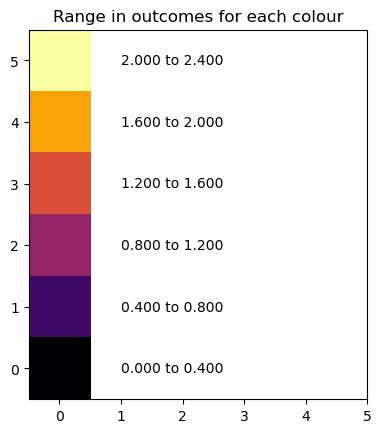

In [18]:
fig, ax = plt.subplots() 

# Draw the colours we've just defined:
ax.imshow(colours_rgba, origin='lower')

# Next to each colour, annotate the range in outcomes it represents:
for c, colour in enumerate(colours):
    bound_lower = outcome_bounds[c]
    bound_higher = outcome_bounds[c+1]
    ax.annotate(
        f'{bound_lower:.3f} to {bound_higher:.3f}',
        xy=(1, c),
        va='center'  # vertical alignment
    )
    
ax.set_title('Range in outcomes for each colour')
# Increase extent to make room for labels:
ax.set_xlim(-0.5, 5)

plt.show()

# UK-wide image: Map outcome values to colours

We'll map colours to the data in this column:

In [19]:
outcome_column = 'drip_ship_lvo_mt_added_utility'

Gather a smaller dataframe of just the bits we need:

In [ ]:
df_outcome_ids = pd.merge(
    df_lsoa_outcomes[['lsoa', outcome_column]],
    df_objectids[['lsoa', 'OBJECTID']],
    on='lsoa',
    how='left'
)

df_outcome_ids

,lsoa,drip_ship_lvo_mt_added_utility,OBJECTID
0,Adur 001A,0.1643,30557
1,Adur 001B,0.1643,30558
2,Adur 001C,0.1091,30559
3,Adur 001D,0.1091,30560
4,Adur 001E,0.1126,30578
...,...,...,...
34747,York 024B,0.1068,12939
34748,York 024C,0.1049,12940
34749,York 024D,0.1068,13019
34750,York 024E,0.1049,13020


... and then make separate lists of the columns because `numba` seems to struggle with multi-dimensional indexing.

In [27]:
LSOA_names_from_df = np.array(df_outcome_ids.to_numpy()[:, 0], dtype=str)
outcome_values_from_df = np.array(df_outcome_ids.to_numpy()[:, 1], dtype=float)
object_id_from_df = np.array(df_outcome_ids.to_numpy()[:, 2], dtype=int)

Set up the colours:

In [24]:
cmap = 'inferno'

outcome_min = min(outcome_values_from_df)
outcome_max = max(outcome_values_from_df)
n_colours = 256

alpha = 1.0  # 0.6

In [25]:
outcome_bounds = np.linspace(outcome_min, outcome_max, n_colours + 1)
colour_bounds = np.linspace(0, 1, n_colours)

# Get RGBA colours:
colours = plt.get_cmap(cmap)(colour_bounds)
# Set all alpha values:
colours[:, 3] = alpha

Define a function for mapping colours to the LSOAs. The output is an array of size NxMx4 where the x4 gives one grid each for red / green / blue / alpha channels.

The `@jit(nopython=True)` above the function name means that it is compiled using `numba`. This speeds up the time it takes to go round all the `for` loops, but with 35,000 LSOAs and a large input array it can still take several minutes to run.

In [72]:
@jit(nopython=True)
def update_colours(
        tif_array,
        colours,
        outcome_bounds, 
        LSOA_names_from_df,
        outcome_values_from_df,
        object_id_from_df
        ):
    """
    Runs 35,000 LSOAs in a 3600x7200 pixel array in 8 minutes.
    """
    # Create a new array that we'll plug the colours into.
    # 4 bands, one for each of red / green / blue / alpha.
    tif_array_colours = np.full((*tif_array[0].shape, 4), 0.0, dtype=np.float64)

    for i, lsoa in enumerate(LSOA_names_from_df):
        outcome_here = outcome_values_from_df[i]
        objectid_here = object_id_from_df[i]

        # Find where this outcome would sit in the list of colour boundaries:
        ind_outcome = np.searchsorted(outcome_bounds, outcome_here)
        if ind_outcome > 0:
            ind_outcome -= 1
        colour = colours[ind_outcome]

        # Find where these OBJECTIDs are in the original array.
        # (this line is particularly slow with big arrays)
        inds_here = np.where(tif_array[0] == objectid_here)

        if len(inds_here[0]) > 0:
            # I can't get numba working with direct slicing, 
            # so update each ind individually:
            for ind, inds in enumerate(inds_here[0]):
                tif_array_colours[ inds_here[0][ind], inds_here[1][ind], :] = colour

    return tif_array_colours

Run the function for the selected outcome type:

(this can take several minutes)

In [186]:
tif_array_colours = update_colours(
    tif_array,
    colours,
    outcome_bounds,
    LSOA_names_from_df,
    outcome_values_from_df,
    object_id_from_df
)

Plot the result as a sanity check:

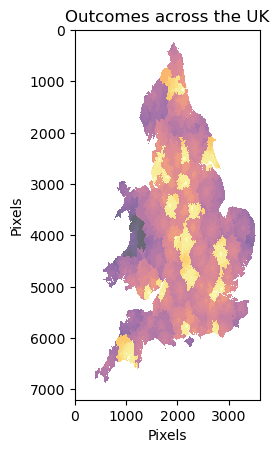

In [188]:
plt.imshow(tif_array_colours, interpolation='None')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Outcomes across the UK')
plt.show()

## Save the results as geotiff

To sanity-check the expected geographic information, the existing .geotiff file can be opened in QGIS. Then in the "Layers" panel, right click on the layer and choose "Properties". This shows the coordinate bounds, EPSG coordinate projection, pixel scale etc.

To save as just a .tif without any of the geographic information, can use the following:
    
    tiff.imwrite('LSOA_raster_colours.tif', tif_array_colours)

Pull out the coordinate transform information from the base geotiff:

In [61]:
# Open the file:
data_orig = gdal.Open(in_tiff, GA_ReadOnly)
# Pull out the info we want:
geoTransform = data_orig.GetGeoTransform()
# Close the file again:
data_orig = None

geoTransform

(-6.623084858,
 0.002386267665277778,
 0.0,
 56.001824295,
 0.0,
 -0.000878866512361111)

Create the new geotiff file:

In [ ]:
out_tiff = f'LSOA_{outcome_column.replace('_', '~')}_raster.tif'

In [47]:
# Following steps in this stackoverflow link:
# https://stackoverflow.com/questions/33537599/how-do-i-write-create-a-geotiff-rgb-image-file-in-python/33950009#33950009

# Create the file:
dst_ds = gdal.GetDriverByName('GTiff').Create(
    out_tiff, # Output file name
    tif_array_colours.shape[1],     # Number of pixels in y
    tif_array_colours.shape[0],     # Number of pixels in x
    4,                              # Number of bands
    gdal.GDT_Float32                # Data type
)

# Set up coordinate metadata:
dst_ds.SetGeoTransform(geoTransform)    # specify coords
srs = osr.SpatialReference()            # establish encoding
srs.ImportFromEPSG(4326)                # WGS84 lat/long
dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file

# Update with the colour data:
dst_ds.GetRasterBand(1).WriteArray(tif_array_colours[:, :, 0])  # red
dst_ds.GetRasterBand(2).WriteArray(tif_array_colours[:, :, 1])  # green
dst_ds.GetRasterBand(3).WriteArray(tif_array_colours[:, :, 2])  # blue
dst_ds.GetRasterBand(4).WriteArray(tif_array_colours[:, :, 3])  # alpha

# Write the file and close it:
dst_ds.FlushCache()
dst_ds = None

## Convert the geotiff to cog

In [54]:
# Tiff input file name:
in_tiff = out_tiff
# Cog output file name:
out_cog = f'LSOA_{outcome_column.replace('_', '~')}_cog.tif'

# Conversion:
leafmap.image_to_cog(in_tiff, out_cog)

# Check that the conversion was successful - if so, prints (True, [], []).
leafmap.cog_validate(out_cog)

Reading input: /home/anna/samuel_book/skeleton-pathway-model/region_matching/LSOA_raster_colours_gdal.tif

Adding overviews...
Updating dataset tags...
Writing output to: /home/anna/samuel_book/skeleton-pathway-model/region_matching/LSOA_cog_colours.tif


(True, [], [])

### Plot the cog

For plotting with imshow(), the array needs to be in the shape NxMx4. When imported using rasterio, the array is initially in the shape 4xNxM. The `np.transpose()` line reshapes the array to the required dimensions.

In [59]:
with rasterio.open(out_cog, 'r') as ds:
    cog_colours_array = ds.read()  # read all raster values
    
cog_colours_array = np.transpose(cog_colours_array, axes=(1, 2, 0))

cog_colours_array.shape

(7200, 3600, 4)

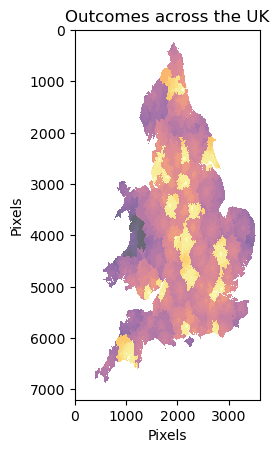

In [60]:
plt.imshow(cog_colours_array, interpolation='None')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Outcomes across the UK')
plt.show()

If this has worked correctly, this plot should look identical to the one from the colour array before it was saved.